## Overview

This project constructs and analyzes developer collaboration networks from GitHub repositories. By treating developers as nodes and shared repository contributions as edges, it reveals hidden structures, community patterns, and technical ecosystems within the GitHub platform.

## Key Features

### Network Construction
- **Automated Graph Building**: BFS-based exploration starting from a seed user
- **Collaborative Edge Detection**: Connects developers who contribute to the same repositories
- **Bot Filtering**: Automatically excludes bot accounts from the network
- **Resumable Collection**: Saves progress periodically to handle API rate limits

### Network Analysis
- **Global Network Properties**: Density, clustering coefficient, degree distribution, and assortativity
- **Community Detection**: Louvain algorithm implementation to identify structural communities
- **Centrality Metrics**: Degree and betweenness centrality analysis within communities
- **Language Ecosystem Mapping**: Tracks programming language distributions across the network

### Semantic Analysis
- **README Text Mining**: Extracts and processes project documentation
- **TF-IDF Analysis**: Identifies distinctive vocabulary for each community
- **Sentiment Analysis**: VADER-based sentiment scoring of documentation
- **Word Cloud Visualization**: Visual representation of community-specific terminology

In [1]:
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import STOPWORDS
import re
import nltk
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import logging
import sys
import nest_asyncio
from dotenv import load_dotenv
import networkx as nx
import asyncio
import aiohttp
import json
import base64
import os
from typing import Dict, Set, Optional
import random
import zipfile
nest_asyncio.apply()

load_dotenv()
BASE = "https://api.github.com"
TOKEN = os.getenv("TOKEN")
HEADERS = {"Authorization": f"token {TOKEN}"} if TOKEN else {}
GRAPH_FILE = "github_graph.gexf"
GRAPH_ZIP = "CopyOfGraph.zip"
SEED_USER = "gh05tdog"
DEPTH = 2
REPO_LIMIT = 40
CONTRIBUTOR_LIMIT = 400

# Graph generation
Build a network graph from GitHub users and their repository collaborations using the GitHub API.

## Logging Configuration
Custom logger to track graph building progress with depth, user, and repository context.

In [2]:
# This is for the loggin
class GitHubGraphFormatter(logging.Formatter):
    def format(self, record):
        # Extract custom attributes if they exist
        depth = getattr(record, 'depth', None)
        user = getattr(record, 'user', None)
        repo = getattr(record, 'repo', None)
        time = self.formatTime(record, self.datefmt)

        # Create prefix based on available information
        prefix = ""
        if depth is not None:
            prefix += f"[DEPTH:{depth}]"
        if user is not None:
            prefix += f"[USER:{user}]"
        if repo is not None:
            prefix += f"[REPO:{repo}]"

        if prefix:
            prefix += " "

        # Format the message with the prefix
        return f"[{time}] {prefix}{super().format(record)}"

# Configure logger
logger = logging.getLogger("github_graph")
logger.setLevel(logging.INFO)  # Set to DEBUG to see more detailed logs

# Prevent duplicate log messages
logger.propagate = False
if logger.handlers:
    logger.handlers.clear()

# Create console handler for INFO and above
console_handler = logging.StreamHandler(sys.stdout)
console_handler.setLevel(logging.INFO)

# Create formatter and add it to the handler
formatter = GitHubGraphFormatter('%(levelname)s: %(message)s')
console_handler.setFormatter(formatter)

# Add handler to logger
logger.addHandler(console_handler)

# Optionally, add a file handler to capture all logs including DEBUG
file_handler = logging.FileHandler('github_graph.log', mode='w')
file_handler.setLevel(logging.DEBUG)
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

logger.info("Logging system initialized")
logger.debug("Debug logging enabled - check github_graph.log for detailed logs")

# Function to control log verbosity
def set_log_level(level):
    if isinstance(level, str):
        level = getattr(logging, level.upper())

    logger.setLevel(level)
    console_handler.setLevel(level)

    level_name = logging.getLevelName(level)
    logger.info(f"Console log level set to {level_name}")




[2025-12-10 20:54:56,347] INFO: Logging system initialized


## GitHub API Functions
Fetch repository and contributor data from GitHub with rate limit handling.

In [3]:
async def get_repos(session, user, limit=20):
    """Fetch repositories owned by a user. And the languages used in each repo."""
    url = f"{BASE}/users/{user}/repos"
    logger.debug(f"Fetching repositories for user '{user}' (limit: {limit})",
                extra={"user": user})

    async with session.get(url, headers=HEADERS, params={"per_page": limit}) as response:
        if response.status == 200:
            data = await response.json()
            repos = [(repo["name"], repo.get("language")) for repo in data]
            logger.debug(f"Successfully fetched {len(repos)} repositories for user '{user}'",
                        extra={"user": user})
            return repos
        elif response.status == 403 and 'X-RateLimit-Remaining' in response.headers and int(response.headers['X-RateLimit-Remaining']) == 0:
            logger.error(f"Rate limit exceeded for user '{user}'", extra={"user": user})
            raise RateLimitExceeded(f"GitHub API rate limit exceeded for user '{user}'")
        else:
            logger.warning(f"Failed to fetch repositories for user '{user}': HTTP {response.status}",
                          extra={"user": user})
            response.raise_for_status()
            return []

async def get_contributors(session, user, repo, limit=20):
    """Fetch contributors for a repository."""
    url = f"{BASE}/repos/{user}/{repo}/contributors"
    logger.debug(f"Fetching contributors for repository '{user}/{repo}' (limit: {limit})",
                extra={"user": user, "repo": repo})

    async with session.get(url, headers=HEADERS, params={"per_page": limit}) as response:
        if response.status == 200:
            data = await response.json()
            contributors = [c["login"] for c in data]
            logger.debug(f"Successfully fetched {len(contributors)} contributors for '{user}/{repo}'",
                        extra={"user": user, "repo": repo})
            return contributors
        elif response.status == 404:
            logger.warning(f"Repository '{user}/{repo}' not found (HTTP 404)",
                          extra={"user": user, "repo": repo})
            return []
        elif response.status == 403 and 'X-RateLimit-Remaining' in response.headers and int(response.headers['X-RateLimit-Remaining']) == 0:
            logger.error(f"Rate limit exceeded for repository '{user}/{repo}'", extra={"user": user, "repo": repo})
            raise RateLimitExceeded(f"GitHub API rate limit exceeded for repository '{user}/{repo}'")
        else:
            logger.warning(f"Failed to fetch contributors for '{user}/{repo}': HTTP {response.status}",
                          extra={"user": user, "repo": repo})
            response.raise_for_status()
            return []

# Custom exception for rate limit
class RateLimitExceeded(Exception):
    """Exception raised when GitHub API rate limit is exceeded."""
    pass


## Data Persistence
Functions to save graph structure and language mappings to files.

In [4]:
def save_graph(G, graph_file):
    """Save the graph to a file, converting set attributes to strings for GEXF compatibility."""
    if not graph_file:
        graph_file = GRAPH_FILE

    logger.info(f"Saving current progress to {graph_file}")
    G_save = G.copy()

    for node, data in G_save.nodes(data=True):
        for key, val in list(data.items()):
            if isinstance(val, set):
                data[key] = ", ".join(sorted(val))

    for node, data in G_save.nodes(data=True):
        G_save.nodes[node]["label"] = node
        if isinstance(data.get("repos"), set):
            G_save.nodes[node]["repos"] = ", ".join(sorted(data["repos"]))
        elif "repos" not in data:
            G_save.nodes[node]["repos"] = ""

    nx.write_gexf(G_save, graph_file)
    logger.info(f"Saved graph with {len(G_save.nodes())} nodes and {len(G_save.edges())} edges to {graph_file}")
    return G_save


## Graph Building Algorithm
Breadth-first exploration of GitHub users through their repositories and collaborators.

In [5]:
async def build_graph(seed_user, depth=2, repo_limit=10, contrib_limit=40, graph_file=None):
    # Start fresh
    G = nx.Graph()
    visited = set()
    exploration_queue = [(seed_user, 0)]  # (user, depth)

    logger.info(
        f"Starting graph building with seed user: {seed_user}",
        extra={"user": seed_user}
    )

    logger.info(
        f"Parameters - Depth: {depth}, Repo limit: {repo_limit}, Contributor limit: {contrib_limit}"
    )

    async with aiohttp.ClientSession() as session:
        # Process the exploration queue
        while exploration_queue:
            user, d = exploration_queue.pop(0)

            # Skip if already visited or beyond depth limit
            if user in visited or d > depth:
                continue

            # Skip bots immediately
            if "[bot]" in user.lower():
                logger.debug(f"Skipping bot user '{user}' entirely")
                continue

            visited.add(user)
            indent = "  " * d
            logger.info(f"{indent}Exploring user '{user}' at depth {d}",
                        extra={"depth": d, "user": user})

            # Fetch repositories for this user
            try:
                repos = await get_repos(session, user, repo_limit)
                logger.info(f"{indent}Found {len(repos)} repositories for user '{user}'",
                extra={"depth": d, "user": user})
            except RateLimitExceeded as e:
                logger.error(f"{indent}Rate limit exceeded for user '{user}': {str(e)}")
                # Save state for resuming

                save_graph(G, graph_file)
                return G
            except aiohttp.ClientError as e:
                logger.error(f"{indent}Failed to fetch repositories for user '{user}': {str(e)}")
                continue

            # Process each repository
            for repo_name in repos:
                full_repo = f"{user}/{repo_name}"

                logger.info(f"{indent}Processing repository: {full_repo}",
                            extra={"depth": d, "user": user, "repo": full_repo})

                try:
                    contributors = await get_contributors(session, user, repo_name, contrib_limit)
                    logger.info(f"{indent}Found {len(contributors)} contributors for {full_repo}",
                                extra={"depth": d, "user": user, "repo": full_repo})
                except RateLimitExceeded as e:
                    logger.error(f"{indent}Rate limit exceeded for repository '{full_repo}': {str(e)}")
                    # Save state for resuming
                    save_graph(G, graph_file)
                    return G
                except aiohttp.ClientError as e:
                    logger.warning(f"{indent}Failed to fetch contributors for {full_repo}: {str(e)}")
                    continue

                # Filter out bots right away
                human_contributors = [c for c in contributors if "[bot]" not in c.lower()]
                if len(human_contributors) < len(contributors):
                    logger.debug(f"{indent}Skipped {len(contributors) - len(human_contributors)} bots in {full_repo}")


                # Add contributors as nodes
                nodes_added = 0
                for c in human_contributors:
                    if c not in G:
                        G.add_node(c, repos=set())
                        nodes_added += 1
                    G.nodes[c]["repos"].add(full_repo)

                if nodes_added > 0:
                    logger.info(f"{indent}Added {nodes_added} new nodes for repository {full_repo}")

                # Connect collaborators (undirected)
                edges_added = 0
                for i, c1 in enumerate(human_contributors):
                    for c2 in human_contributors[i + 1:]:
                        G.add_edge(c1, c2, repo=full_repo)
                        edges_added += 1

                if edges_added > 0:
                    logger.info(f"{indent}Added {edges_added} edges for repository {full_repo}")

                # Add contributors to the exploration queue for the next depth level
                for contributor in human_contributors:
                    if contributor not in visited:
                        exploration_queue.append((contributor, d + 1))

            # Periodically save progress
            if len(visited) % 10 == 0:
                save_graph(G, graph_file)

    logger.info(f"Graph building completed. Final graph has {len(G.nodes())} nodes and {len(G.edges())} edges.")

    # Save final state
    save_graph(G, graph_file)

    return G


In [6]:
# Define an async function to run the graph building process
async def run_graph_building():
    GRAPH_PATH = "CopyOfGraph/" + GRAPH_FILE
    if os.path.exists(GRAPH_PATH):
        logger.info(f"Loading existing graph from {GRAPH_PATH}")
        G = nx.read_gexf(GRAPH_PATH)
        logger.warning("Loaded existing graph without language data. Run a fresh build to collect language information.")
    # Start fresh
    else:
        logger.info("Building new graph...")
        G = await build_graph(SEED_USER, depth=DEPTH, contrib_limit=CONTRIBUTOR_LIMIT,
                             repo_limit=REPO_LIMIT, graph_file=GRAPH_FILE)

        # If the graph was saved during building due to rate limit, it's already in the right format
        # Otherwise, save it now
        if not os.path.exists(GRAPH_FILE):
            G_save = save_graph(G, GRAPH_FILE)
            G = G_save

    return G


In [7]:
if os.path.exists(GRAPH_ZIP) and not os.path.exists(GRAPH_FILE):
    logger.info(f"Extracting {GRAPH_ZIP}...")
    with zipfile.ZipFile(GRAPH_ZIP, 'r') as zip_ref:
        zip_ref.extractall()
    logger.info("Extraction complete")

# Run the async function using asyncio
try:
    G = asyncio.run(run_graph_building())
except KeyboardInterrupt:
    logger.info("Process interrupted by user. Progress has been saved and can be resumed.")
    if os.path.exists(GRAPH_FILE):
        logger.info(f"Loading saved graph from {GRAPH_FILE}")
        G = nx.read_gexf(GRAPH_FILE)
    else:
        logger.error("No saved graph. Exiting.")
        raise

logger.info(f"Graph statistics: {len(G.nodes())} nodes, {len(G.edges())} edges")


[2025-12-10 20:54:56,390] INFO: Extracting CopyOfGraph.zip...
[2025-12-10 20:54:56,843] INFO: Extraction complete
[2025-12-10 20:54:56,844] INFO: Loading existing graph from CopyOfGraph/github_graph.gexf
[2025-12-10 20:55:19,755] WARNING: Loaded existing graph without language data. Run a fresh build to collect language information.
[2025-12-10 20:55:19,764] INFO: Graph statistics: 48951 nodes, 2279238 edges


## Repository Data Collection
Fetch detailed language and README data for repositories in the graph.

In [8]:
async def get_repo_languages(session: aiohttp.ClientSession, owner: str, repo: str) -> Dict[str, int]:
    url = f"{BASE}/repos/{owner}/{repo}/languages"
    
    try:
        async with session.get(url, headers=HEADERS) as response:
            if response.status == 200:
                data = await response.json()
                logger.debug(f"Fetched languages for {owner}/{repo}: {list(data.keys())}")
                return data
            elif response.status == 404:
                logger.warning(f"Repository {owner}/{repo} not found")
                return {}
            elif response.status == 403:
                remaining = response.headers.get('X-RateLimit-Remaining', '?')
                if remaining == '0':
                    reset_time = response.headers.get('X-RateLimit-Reset', '?')
                    raise RateLimitExceeded(f"Rate limit exceeded. Reset at {reset_time}")
                logger.warning(f"Access forbidden for {owner}/{repo}")
                return {}
            else:
                logger.warning(f"Failed to fetch languages for {owner}/{repo}: HTTP {response.status}")
                return {}
    except aiohttp.ClientError as e:
        logger.error(f"Network error fetching languages for {owner}/{repo}: {str(e)}")
        return {}

async def get_repo_readme(session: aiohttp.ClientSession, owner: str, repo: str, max_size: int = 50000) -> Optional[str]:

    url = f"{BASE}/repos/{owner}/{repo}/readme"
    
    try:
        async with session.get(url, headers=HEADERS) as response:
            if response.status == 200:
                data = await response.json()
                # GitHub returns base64 encoded content
                content_b64 = data.get("content", "")
                if content_b64:
                    try:
                        # Decode base64
                        content = base64.b64decode(content_b64).decode('utf-8')
                        # Truncate if too large
                        if len(content) > max_size:
                            logger.debug(f"Truncating README for {owner}/{repo} from {len(content)} to {max_size} chars")
                            content = content[:max_size] + "\n...[truncated]"
                        logger.debug(f"Fetched README for {owner}/{repo} ({len(content)} chars)")
                        return content
                    except Exception as e:
                        logger.error(f"Failed to decode README for {owner}/{repo}: {str(e)}")
                        return None
                return None
            elif response.status == 404:
                logger.debug(f"No README found for {owner}/{repo}")
                return None
            elif response.status == 403:
                remaining = response.headers.get('X-RateLimit-Remaining', '?')
                if remaining == '0':
                    reset_time = response.headers.get('X-RateLimit-Reset', '?')
                    raise RateLimitExceeded(f"Rate limit exceeded. Reset at {reset_time}")
                logger.warning(f"Access forbidden for {owner}/{repo}")
                return None
            else:
                logger.warning(f"Failed to fetch README for {owner}/{repo}: HTTP {response.status}")
                return None
    except aiohttp.ClientError as e:
        logger.error(f"Network error fetching README for {owner}/{repo}: {str(e)}")
        return None

async def fetch_repo_data(session: aiohttp.ClientSession, repo: str, max_readme_size: int = 50000) -> tuple:

    owner, repo_name = repo.split("/", 1)
    
    # Fetch languages and README in parallel
    lang_task = get_repo_languages(session, owner, repo_name)
    readme_task = get_repo_readme(session, owner, repo_name, max_readme_size)
    
    lang_data, readme = await asyncio.gather(lang_task, readme_task)
    
    # Determine primary language
    primary_lang = None
    if lang_data:
        primary_lang = max(lang_data, key=lang_data.get)
    
    data = {
        "languages": lang_data,
        "primary_language": primary_lang,
        "readme": readme,
        "total_bytes": sum(lang_data.values()) if lang_data else 0
    }
    
    return repo, data

def save_json(data: dict, filename: str):
    """Save data to JSON file."""
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(data, f, indent=2, ensure_ascii=False)
    logger.info(f"Saved data to {filename}")

def load_json(filename: str) -> dict:
    """Load data from JSON file."""
    if not os.path.exists(filename):
        return {}
    with open(filename, 'r', encoding='utf-8') as f:
        return json.load(f)

def extract_repos_from_graph(G) -> Set[str]:
    all_repos = set()
    
    for node, data in G.nodes(data=True):
        repos_str = data.get("repos", "")
        if repos_str:
            # Handle both comma-separated strings and single repos
            if "," in repos_str:
                repos = [r.strip() for r in repos_str.split(",")]
            else:
                repos = [repos_str.strip()]
            
            # Only add valid "owner/repo" format
            for repo in repos:
                if repo and "/" in repo:
                    all_repos.add(repo)
    
    logger.info(f"Extracted {len(all_repos)} unique repositories from graph")
    return all_repos

async def collect_repo_data(G, output_file: str = "repo_data.json", 
                           progress_file: str = "repo_data_progress.json",
                           max_readme_size: int = 50000,
                           batch_size: int = 50,
                           max_concurrent: int = 10):
    # Extract unique repos from graph
    all_repos = extract_repos_from_graph(G)
    all_repos = sorted(all_repos)  # Sort for consistent ordering
    
    # Load any existing progress
    repo_data = load_json(progress_file)
    already_processed = set(repo_data.keys())
    remaining_repos = [r for r in all_repos if r not in already_processed]
    
    if already_processed:
        logger.info(f"Resuming from progress file: {len(already_processed)} repos already processed")
    
    logger.info(f"Need to process {len(remaining_repos)} repositories")
    logger.info(f"Using batch_size={batch_size}, max_concurrent={max_concurrent}")
    
    if not remaining_repos:
        logger.info("All repos already processed!")
        save_json(repo_data, output_file)
        return repo_data
    
    # Create semaphore to limit concurrent requests
    semaphore = asyncio.Semaphore(max_concurrent)
    
    async def fetch_with_semaphore(session, repo):
        """Wrapper to limit concurrent requests."""
        async with semaphore:
            try:
                return await fetch_repo_data(session, repo, max_readme_size)
            except RateLimitExceeded:
                raise
            except Exception as e:
                logger.error(f"Error processing {repo}: {str(e)}")
                return repo, None
    
    # Process repos in batches
    async with aiohttp.ClientSession() as session:
        for batch_start in range(0, len(remaining_repos), batch_size):
            batch_end = min(batch_start + batch_size, len(remaining_repos))
            batch = remaining_repos[batch_start:batch_end]
            
            logger.info(f"Processing batch {batch_start//batch_size + 1}/{(len(remaining_repos)-1)//batch_size + 1} ({len(batch)} repos)")
            
            try:
                # Fetch all repos in batch concurrently
                tasks = [fetch_with_semaphore(session, repo) for repo in batch]
                results = await asyncio.gather(*tasks, return_exceptions=True)
                
                # Process results
                for result in results:
                    if isinstance(result, Exception):
                        if isinstance(result, RateLimitExceeded):
                            logger.error(f"Rate limit exceeded: {str(result)}")
                            logger.info("Saving progress before stopping...")
                            save_json(repo_data, progress_file)
                            logger.info(f"Progress saved to {progress_file}. Run again to resume.")
                            return repo_data
                        else:
                            logger.error(f"Unexpected exception in batch: {str(result)}")
                            continue
                    
                    repo_name, data = result
                    if data is not None:
                        repo_data[repo_name] = data
                
                # Save progress after each batch
                save_json(repo_data, progress_file)
                processed_count = len(repo_data) - len(already_processed)
                logger.info(f"Progress: {processed_count}/{len(remaining_repos)} repos processed ({100*processed_count/len(remaining_repos):.1f}%)")
                
                # Small delay between batches to be nice to the API
                await asyncio.sleep(0.5)
                
            except Exception as e:
                logger.error(f"Error processing batch: {str(e)}")
                save_json(repo_data, progress_file)
                continue
    
    # Save final results
    save_json(repo_data, output_file)
    logger.info(f"Complete! Processed {len(repo_data)} repositories")
    logger.info(f"Final data saved to {output_file}")
    
    # Clean up progress file
    if os.path.exists(progress_file):
        os.remove(progress_file)
        logger.info(f"Removed progress file {progress_file}")
    
    return repo_data

In [9]:
# Collect repo data (with parallel processing)
repo_data = await collect_repo_data(
    G,
    output_file="repo_data.json",
    progress_file="repo_data_progress.json",
    batch_size=100,          # Process 100 repos per batch
    max_concurrent=20        # Max 20 concurrent API requests
)

[2025-12-10 20:55:19,808] INFO: Extracted 4554 unique repositories from graph
[2025-12-10 20:55:19,809] INFO: Need to process 4554 repositories
[2025-12-10 20:55:19,809] INFO: Using batch_size=100, max_concurrent=20
[2025-12-10 20:55:19,809] INFO: Processing batch 1/46 (100 repos)
[2025-12-10 20:55:19,907] WARNING: Failed to fetch languages for Andru1999/tech-db-lectures: HTTP 429
[2025-12-10 20:55:19,907] WARNING: Failed to fetch languages for AndydeCleyre/1576: HTTP 429
[2025-12-10 20:55:19,908] WARNING: Failed to fetch README for Andru1999/tech-db-lectures: HTTP 429
[2025-12-10 20:55:19,908] WARNING: Failed to fetch languages for AndydeCleyre/AndydeCleyre: HTTP 429
[2025-12-10 20:55:19,908] WARNING: Failed to fetch languages for AndydeCleyre/advent-of-code-2021: HTTP 429
[2025-12-10 20:55:19,908] WARNING: Failed to fetch languages for AndydeCleyre/advent-of-code-2018: HTTP 429
[2025-12-10 20:55:19,909] WARNING: Failed to fetch README for AndydeCleyre/Circle-Flat-Icon: HTTP 429
[2025

# Network Connectivity Analysis
Load and analyze the largest connected component of the GitHub collaboration network.

In [10]:
# Read the graph
components = list(nx.connected_components(G))

component_sizes = sorted([len(c) for c in components], reverse=True)

largest_cc = max(components, key=len)
G = G.subgraph(largest_cc).copy()

print(f"\nFiltered network (largest component only):")
print(f"  Nodes: {G.number_of_nodes()}")
print(f"  Edges: {G.number_of_edges()}")
print(f"  Connected: {nx.is_connected(G)}")



Filtered network (largest component only):
  Nodes: 47579
  Edges: 2270752
  Connected: True


# Network Statistics
Calculate key metrics to understand the structure of the developer network.

## Network density

In [11]:
density = nx.density(G)
print(f"Network density: {density:.4f}")

avg_clustering = nx.average_clustering(G.to_undirected())
print(f"Average clustering coefficient: {avg_clustering:.4f}")

Network density: 0.0020
Average clustering coefficient: 0.9249


## Average degree

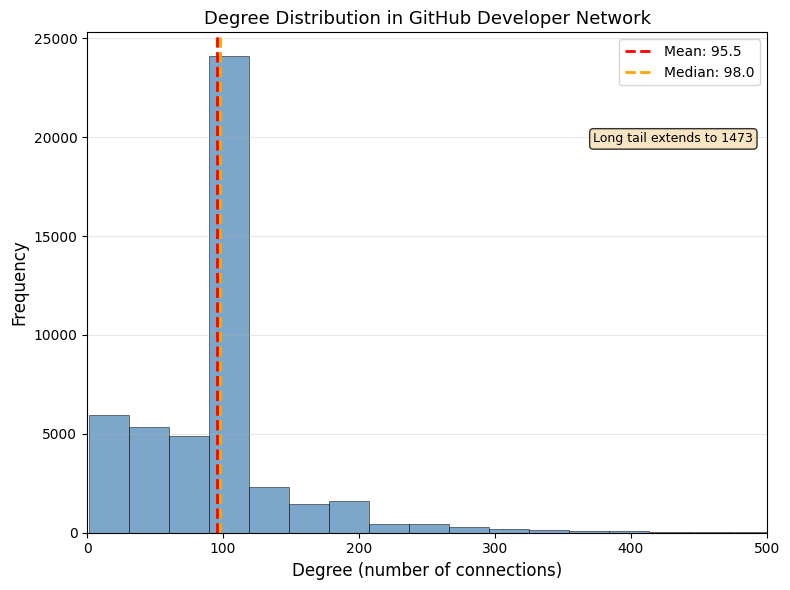

In [12]:
degrees = [G.degree(node) for node in G.nodes()]
mean_deg = np.mean(degrees)
median_deg = np.median(degrees)

plt.figure(figsize=(8, 6))
plt.hist(degrees, bins=50, alpha=0.7, edgecolor='black', linewidth=0.5, color='steelblue')
plt.axvline(mean_deg, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_deg:.1f}')
plt.axvline(median_deg, color='orange', linestyle='--', linewidth=2, label=f'Median: {median_deg:.1f}')
plt.xlabel('Degree (number of connections)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Degree Distribution in GitHub Developer Network', fontsize=13)
plt.legend(fontsize=10, loc='upper right')
plt.grid(True, alpha=0.3, axis='y')
plt.xlim(0, 500)  # Zoom to where most of the data is

# Add note about long tail
plt.text(0.98, 0.8, f'Long tail extends to {max(degrees)}',
         transform=plt.gca().transAxes,
         fontsize=9, verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

## Degree assortativity

In [13]:
G_undirected = G
assortativity = nx.degree_assortativity_coefficient(G_undirected)
print(f"Degree Assortativity Coefficient: {assortativity:.4f}")

Degree Assortativity Coefficient: 0.1304


# Community Detection
Identify developer communities using the Louvain algorithm for modularity optimization.


In [14]:
def detect_structural_communities(G):
    communities = nx.community.louvain_communities(G, seed=123)
    partition = {}
    for comm_id, community in enumerate(communities):
        for node in community:
            partition[node] = comm_id
    modularity = nx.community.modularity(G, communities)
    return communities, partition, modularity

communities, partition, modularity = detect_structural_communities(G)

print(f"Found {len(communities)} communities")
print(f"Modularity: {modularity:.4f}")

# Get community sizes
sizes = [(i, len(comm)) for i, comm in enumerate(communities)]
sizes.sort(key=lambda x: x[1], reverse=True)

print("\nTop 10 communities:")
for rank, (comm_id, size) in enumerate(sizes[:10], 1):
    pct = (size / len(partition)) * 100
    print(f"  {rank}. Community {comm_id}: {size} nodes ({pct:.1f}%)")


Found 77 communities
Modularity: 0.8588

Top 10 communities:
  1. Community 23: 2630 nodes (5.5%)
  2. Community 1: 2486 nodes (5.2%)
  3. Community 14: 1900 nodes (4.0%)
  4. Community 59: 1727 nodes (3.6%)
  5. Community 22: 1674 nodes (3.5%)
  6. Community 40: 1509 nodes (3.2%)
  7. Community 69: 1481 nodes (3.1%)
  8. Community 9: 1448 nodes (3.0%)
  9. Community 16: 1406 nodes (3.0%)
  10. Community 38: 1271 nodes (2.7%)


# Community Language Analysis
Analyze dominant programming languages within each detected community.

In [15]:
def analyze_community_languages(communities, partition, repo_data):
    """
    Find dominant languages for each community.
    """
    community_languages = {}

    for comm_id in range(len(communities)):
        # Get all users in this community
        users = [node for node, c in partition.items() if c == comm_id]

        # Count language bytes for this community
        lang_bytes = {}
        for user in users:
            # Get repos for this user from G graph
            repos_str = G.nodes[user].get("repos", "")
            if repos_str:
                repos = [r.strip() for r in repos_str.split(",")]
                for repo in repos:
                    if repo in repo_data:
                        languages = repo_data[repo].get("languages", {})
                        for lang, bytes_count in languages.items():
                            if lang not in lang_bytes:
                                lang_bytes[lang] = 0
                            lang_bytes[lang] += bytes_count

        community_languages[comm_id] = lang_bytes

    return community_languages


with open("repo_data.json", "r", encoding="utf-8") as f:
    repo_data = json.load(f)
# Analyze languages per community
comm_langs = analyze_community_languages(communities, partition, repo_data)

# Show top 3 languages for top 10 communities
print("Top languages per community:\n")
for rank, (comm_id, size) in enumerate(sizes[:10], 1):
    langs = comm_langs[comm_id]
    total = sum(langs.values())
    top_langs = sorted(langs.items(), key=lambda x: x[1], reverse=True)[:3]

    print(f"{rank}. Community {comm_id} ({size} nodes):")
    for lang, bytes_count in top_langs:
        pct = (bytes_count / total * 100) if total > 0 else 0
        print(f"   - {lang}: {pct:.1f}%")
    print()

Top languages per community:

1. Community 23 (2630 nodes):
   - Python: 69.2%
   - C: 15.4%
   - PHP: 4.6%

2. Community 1 (2486 nodes):
   - Java: 74.4%
   - TypeScript: 16.3%
   - JavaScript: 3.3%

3. Community 14 (1900 nodes):
   - Java: 79.8%
   - C++: 10.9%
   - C: 3.7%

4. Community 59 (1727 nodes):
   - C: 87.2%
   - C++: 4.8%
   - Java: 1.7%

5. Community 22 (1674 nodes):
   - Java: 31.3%
   - Scala: 17.6%
   - Python: 15.3%

6. Community 40 (1509 nodes):
   - Python: 48.4%
   - C++: 19.7%
   - Rust: 9.6%

7. Community 69 (1481 nodes):
   - Go: 79.0%
   - Python: 4.7%
   - C: 3.1%

8. Community 9 (1448 nodes):
   - Go: 73.5%
   - Markdown: 5.1%
   - C: 4.2%

9. Community 16 (1406 nodes):
   - C: 36.1%
   - Go: 34.2%
   - TypeScript: 21.1%

10. Community 38 (1271 nodes):
   - TypeScript: 82.7%
   - JavaScript: 5.3%
   - Markdown: 5.0%



In [16]:
def normalize_languages(comm_langs):
    """
    Group related languages together.
    - Java + Scala + Kotlin -> Java (JVM languages)
    - C + C++ -> C/C++
    """
    language_groups = {
        # JVM languages
        'Java': 'Java',
        'Scala': 'Java',
        'Kotlin': 'Java',

        # C family
        'C': 'C/C++',
        'C++': 'C/C++',
    }

    normalized_comm_langs = {}

    for comm_id, langs in comm_langs.items():
        normalized_langs = {}

        for lang, bytes_count in langs.items():
            # Map to group or keep original
            normalized_lang = language_groups.get(lang, lang)

            if normalized_lang not in normalized_langs:
                normalized_langs[normalized_lang] = 0
            normalized_langs[normalized_lang] += bytes_count

        normalized_comm_langs[comm_id] = normalized_langs

    return normalized_comm_langs

# Normalize languages before calculating purity
comm_langs_normalized = normalize_languages(comm_langs)

def calculate_language_purity(comm_langs, top_k=10):
    """
    Calculate purity for each community.
    Purity = percentage of bytes in the dominant language.
    """
    purity_scores = {}

    for comm_id, langs in comm_langs.items():
        if not langs:
            continue

        total = sum(langs.values())
        max_bytes = max(langs.values())
        purity = (max_bytes / total * 100) if total > 0 else 0
        dominant_lang = max(langs, key=langs.get)

        purity_scores[comm_id] = {
            'purity': purity,
            'dominant_language': dominant_lang,
            'total_bytes': total
        }

    return purity_scores

# Use normalized languages
purity_scores = calculate_language_purity(comm_langs_normalized)

# Show purity for top communities
print("\nLanguage Purity for Top  Communities (with language grouping):")
print(f"{'Community':<15} {'Size':<10} {'Dominant Lang':<20} {'Purity'}")
print("-" * 70)

for rank, (comm_id, size) in enumerate(sizes[:5], 1):
    if comm_id in purity_scores:
        info = purity_scores[comm_id]
        print(f"Community {comm_id:<5} {size:<10} {info['dominant_language']:<20} {info['purity']:.1f}%")

# Calculate average purity across top communities
top_10_ids = [comm_id for comm_id, _ in sizes]
avg_purity = np.mean([purity_scores[cid]['purity'] for cid in top_10_ids if cid in purity_scores])
print(f"\nAverage purity across communities: {avg_purity:.1f}%")


Language Purity for Top  Communities (with language grouping):
Community       Size       Dominant Lang        Purity
----------------------------------------------------------------------
Community 23    2630       Python               69.2%
Community 1     2486       Java                 74.4%
Community 14    1900       Java                 79.9%
Community 59    1727       C/C++                92.0%
Community 22    1674       Java                 49.0%

Average purity across communities: 64.5%


In [17]:
def analyze_community_centrality(G, partition, top_communities, top_n=5):
    """
    Calculate centrality within each community's subgraph.
    Returns top N developers by degree and betweenness for each community.
    """
    community_leaders = {}

    for comm_id, size in top_communities:
        print(f"\nAnalyzing Community {comm_id} ({size} nodes)...")

        # Get subgraph for this community
        comm_nodes = [node for node, c in partition.items() if c == comm_id]
        subgraph = G.subgraph(comm_nodes).copy()

        # Calculate centralities (fast on subgraphs!)
        degree_cent = nx.degree_centrality(subgraph)
        betweenness_cent = nx.betweenness_centrality(subgraph)

        # Get top N
        top_degree = sorted(degree_cent.items(), key=lambda x: x[1], reverse=True)[:top_n]
        top_between = sorted(betweenness_cent.items(), key=lambda x: x[1], reverse=True)[:top_n]

        community_leaders[comm_id] = {
            'size': size,
            'top_degree': top_degree,
            'top_betweenness': top_between
        }

        print(f"  Top {top_n} by degree: {[user for user, _ in top_degree]}")
        print(f"  Top {top_n} by betweenness: {[user for user, _ in top_between]}")

    return community_leaders

# Analyze top 5 communities
top_5_communities = sizes[:5]
community_leaders = analyze_community_centrality(G, partition, top_5_communities, top_n=5)



Analyzing Community 23 (2630 nodes)...
  Top 5 by degree: ['blueyed', 'jdufresne', 'hugovk', 'lovelydinosaur', 'graingert']
  Top 5 by betweenness: ['blueyed', 'jdufresne', 'hugovk', 'graingert', 'mgorny']

Analyzing Community 1 (2486 nodes)...
  Top 5 by degree: ['lcawl', 'clintongormley', 'debadair', 'nik9000', 'ycombinator']
  Top 5 by betweenness: ['lcawl', 'clintongormley', 'debadair', 'ycombinator', 'nik9000']

Analyzing Community 14 (1900 nodes)...
  Top 5 by degree: ['sullis', 'PascalSchumacher', 'valery1707', 'sschuberth', 'michaelhixson']
  Top 5 by betweenness: ['sullis', 'dalbani', 'eclipsewebmaster', 'PascalSchumacher', 'noctarius']

Analyzing Community 59 (1727 nodes)...
  Top 5 by degree: ['cladmi', 'jfischer-no', 'oliverschmidt', 'hexluthor', 'OlegHahm']
  Top 5 by betweenness: ['oliverschmidt', 'wbober', 'greg-fer', 'vsaw', 'HLLissau']

Analyzing Community 22 (1674 nodes)...
  Top 5 by degree: ['xhochy', 'jorisvandenbossche', 'cpcloud', 'julienledem', 'pitrou']
  Top 

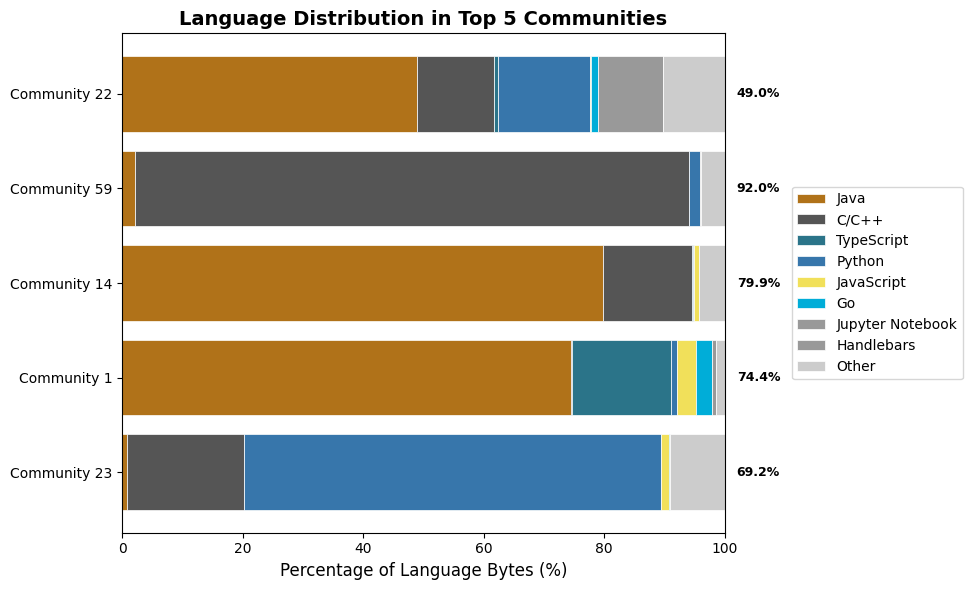

In [18]:

# Get top 5 communities
top_5 = sizes[:5]
comm_ids = [cid for cid, _ in top_5]

# Prepare data
labels = [f"Community {cid}" for cid in comm_ids]
all_languages = set()
for cid in comm_ids:
    all_languages.update(comm_langs_normalized[cid].keys())

# Get top languages across all communities for coloring
lang_totals = {}
for cid in comm_ids:
    for lang, bytes in comm_langs_normalized[cid].items():
        lang_totals[lang] = lang_totals.get(lang, 0) + bytes

top_langs = sorted(lang_totals.keys(), key=lambda x: lang_totals[x], reverse=True)[:8]
other_langs = set(all_languages) - set(top_langs)

# Build percentage data
data = {lang: [] for lang in top_langs}
data['Other'] = []

for cid in comm_ids:
    total = sum(comm_langs_normalized[cid].values())
    for lang in top_langs:
        pct = (comm_langs_normalized[cid].get(lang, 0) / total * 100) if total > 0 else 0
        data[lang].append(pct)

    # Other category
    other_sum = sum(comm_langs_normalized[cid].get(lang, 0) for lang in other_langs)
    other_pct = (other_sum / total * 100) if total > 0 else 0
    data['Other'].append(other_pct)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

# Colors for languages
colors = {
    'Python': '#3776ab',
    'Java': '#b07219',
    'C/C++': '#555555',
    'TypeScript': '#2b7489',
    'JavaScript': '#f1e05a',
    'PHP': '#4F5D95',
    'Go': '#00ADD8',
    'Ruby': '#701516',
    'Other': '#cccccc'
}

# Create stacked bars
bottom = np.zeros(len(comm_ids))
for lang in top_langs + ['Other']:
    values = data[lang]
    ax.barh(labels, values, left=bottom, label=lang,
            color=colors.get(lang, '#999999'), edgecolor='white', linewidth=0.5)
    bottom += values

ax.set_xlabel('Percentage of Language Bytes (%)', fontsize=12)
ax.set_title('Language Distribution in Top 5 Communities', fontsize=14, fontweight='bold')
ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), fontsize=10)
ax.set_xlim(0, 100)

# Add purity percentages as text
for i, cid in enumerate(comm_ids):
    purity = purity_scores[cid]['purity']
    ax.text(102, i, f"{purity:.1f}%", va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# Word Cloud Visualization
Extract and visualize common terms from repository README files.

In [19]:
def extract_readme_texts(repo_data):
    readme_texts = []

    for repo, data in repo_data.items():
        readme = data.get("readme")
        if readme:
            readme_texts.append(readme)

    print(f"Found {len(readme_texts)} repos with READMEs")
    return readme_texts

readmes = extract_readme_texts(repo_data)

Found 3537 repos with READMEs


In [20]:
def clean_readme_text(text):
    """
    Clean a single README text.
    """
    if not text:
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Remove markdown links [text](url)
    text = re.sub(r'\[([^\]]+)\]\([^\)]+\)', r'\1', text)

    # Remove code blocks (```)
    text = re.sub(r'```[\s\S]*?```', '', text)

    # Remove inline code (`)
    text = re.sub(r'`[^`]*`', '', text)

    # Remove special characters but keep spaces
    text = re.sub(r'[^a-z\s]', ' ', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def clean_readmes(readme_texts):
    """
    Clean all README texts.
    """
    cleaned = [clean_readme_text(text) for text in readme_texts]
    print(f"Cleaned {len(cleaned)} READMEs")
    return cleaned

# Clean the readmes
cleaned_readmes = clean_readmes(readmes)

Cleaned 3537 READMEs


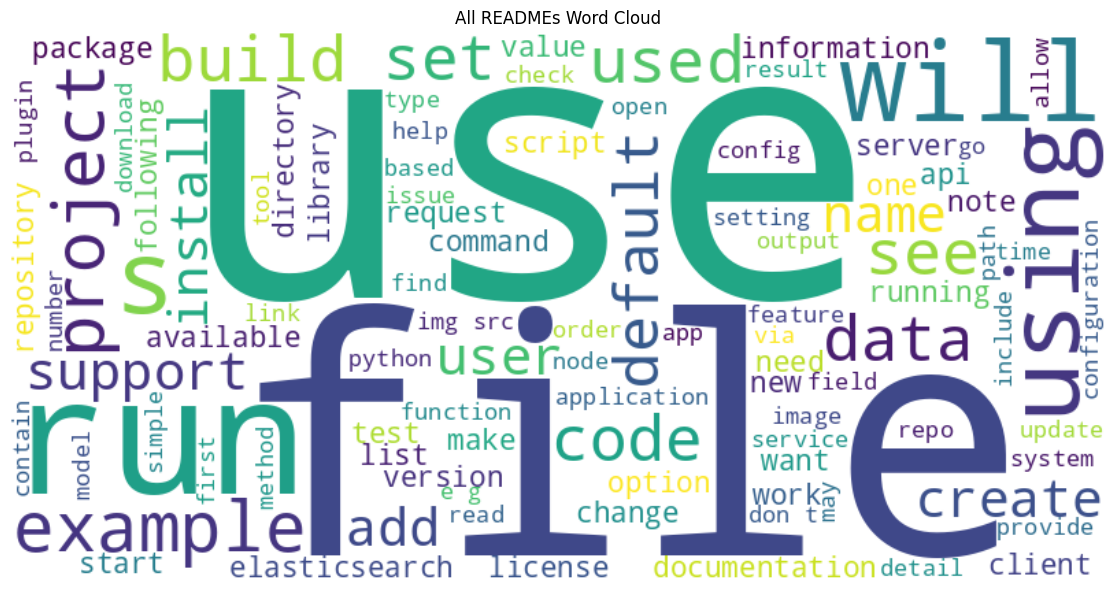

In [21]:
def create_wordcloud(texts, title="Word Cloud"):
    """
    Create a word cloud from a list of texts.

    Parameters:
        texts: list of strings
        title: title for the plot
    """
    # Combine all texts
    combined_text = " ".join(texts)

    # Create word cloud
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=100,
        random_state=42
    ).generate(combined_text)

    # Display
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Create overall word cloud
create_wordcloud(cleaned_readmes, "All READMEs Word Cloud")

# TF-IDF Analysis
Identify distinctive terms for each community using Term Frequency-Inverse Document Frequency.

In [22]:
def get_community_readmes(community_id, partition, repo_data):
    # Get users in this community
    users = [node for node, comm in partition.items() if comm == community_id]

    # Collect their READMEs
    readmes = []
    for user in users:
        repos_str = G.nodes[user].get("repos", "")
        if repos_str:
            repos = [r.strip() for r in repos_str.split(",")]
            for repo in repos:
                if repo in repo_data:
                    readme = repo_data[repo].get("readme")
                    if readme:
                        readmes.append(readme)

    return readmes

def analyze_community_tfidf(community_id, partition, repo_data, top_n=10):
    """
    Find top TF-IDF terms for a specific community.
    """
    # Get READMEs for this community
    readmes = get_community_readmes(community_id, partition, repo_data)

    if not readmes:
        return []

    # Clean the READMEs
    cleaned = [clean_readme_text(text) for text in readmes]

    # Combine into one document for this community
    community_text = " ".join(cleaned)

    return community_text, len(readmes)

# Collect texts for top 5 communities
print("Collecting README texts for top communities...\n")

community_texts = {}
for rank, (comm_id, size) in enumerate(sizes[:6], 1):
    text, readme_count = analyze_community_tfidf(comm_id, partition, repo_data)
    community_texts[comm_id] = text
    print(f"Community {comm_id}: {readme_count} READMEs")


Community 23: 4105 READMEs
Community 1: 19794 READMEs
Community 14: 2789 READMEs
Community 59: 10741 READMEs
Community 22: 2508 READMEs
Community 40: 3451 READMEs


In [23]:
def compare_communities_tfidf(community_texts, top_n=15):
    # Prepare documents (one per community)
    comm_ids = list(community_texts.keys())
    documents = [community_texts[cid] for cid in comm_ids]

    # Custom stopwords
    custom_stopwords = list(STOPWORDS)
    custom_stopwords.extend([
        'use', 'used', 'using', 'run', 'file', 'will', 'one', 'two',
        'project', 'new', 'set', 'may', 'also', 'see', 'get', 'make',
        'example', 'install', 'start', 'first', 'need', 'add', 'name',
        'following', 'via', 'note', 'number', 'type', 'value', 'result',
        'allow', 'include', 'provide', 'contain', 'based', 'support'
    ])

    # Compute TF-IDF
    vectorizer = TfidfVectorizer(
        max_features=1000,
        stop_words=custom_stopwords,
        min_df=1,
        ngram_range=(1, 2)  # Include bigrams
    )

    tfidf_matrix = vectorizer.fit_transform(documents)
    feature_names = vectorizer.get_feature_names_out()

    # Get top terms for each community
    print(f"{'Community':<15} {'Top Distinctive Terms'}")
    print("=" * 80)

    for idx, comm_id in enumerate(comm_ids):
        # Get TF-IDF scores for this community
        scores = tfidf_matrix[idx].toarray()[0]
        top_indices = scores.argsort()[-top_n:][::-1]
        top_terms = [feature_names[i] for i in top_indices]

        # Get dominant language for context
        if comm_id in comm_langs_normalized:
            langs = comm_langs_normalized[comm_id]
            top_lang = max(langs, key=langs.get)
        else:
            top_lang = "Unknown"

        print(f"\nCommunity {comm_id:<5} ({top_lang}):")
        print(f"  {', '.join(top_terms)}")

# Run TF-IDF comparison
compare_communities_tfidf(community_texts, top_n=15)

/home/marcus/.pyenv/versions/global_env/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


Community       Top Distinctive Terms

Community 23    (Python):
  python, td, code, target, faker, django, image, docs, td td, redis, href, url, version, img, alt

Community 1     (Java):
  elasticsearch, kibana, index, license, search, elastic, version, build, data, source, asciidoc, left valign, es, curl, pre

Community 14    (Java):
  mph, license, hazelcast, java, build, tests, sup, version, data, sdk, eclipse, aws, software, gradle, code

Community 59    (C/C++):
  contiki, contiki ng, yolov, monitoring, yolo, low power, power, zzzzz, code, fps, source, zzzz, low, ng, system

Community 22    (Java):
  image, license, spark, status, apache, python, data, alt, build, documentation, version, hadoop, target, src, distributed

Community 40    (Python):
  message, bot, telebot, api, text, telegram, python, handlers, messages, message handlers, function, types, handler, chat, large text


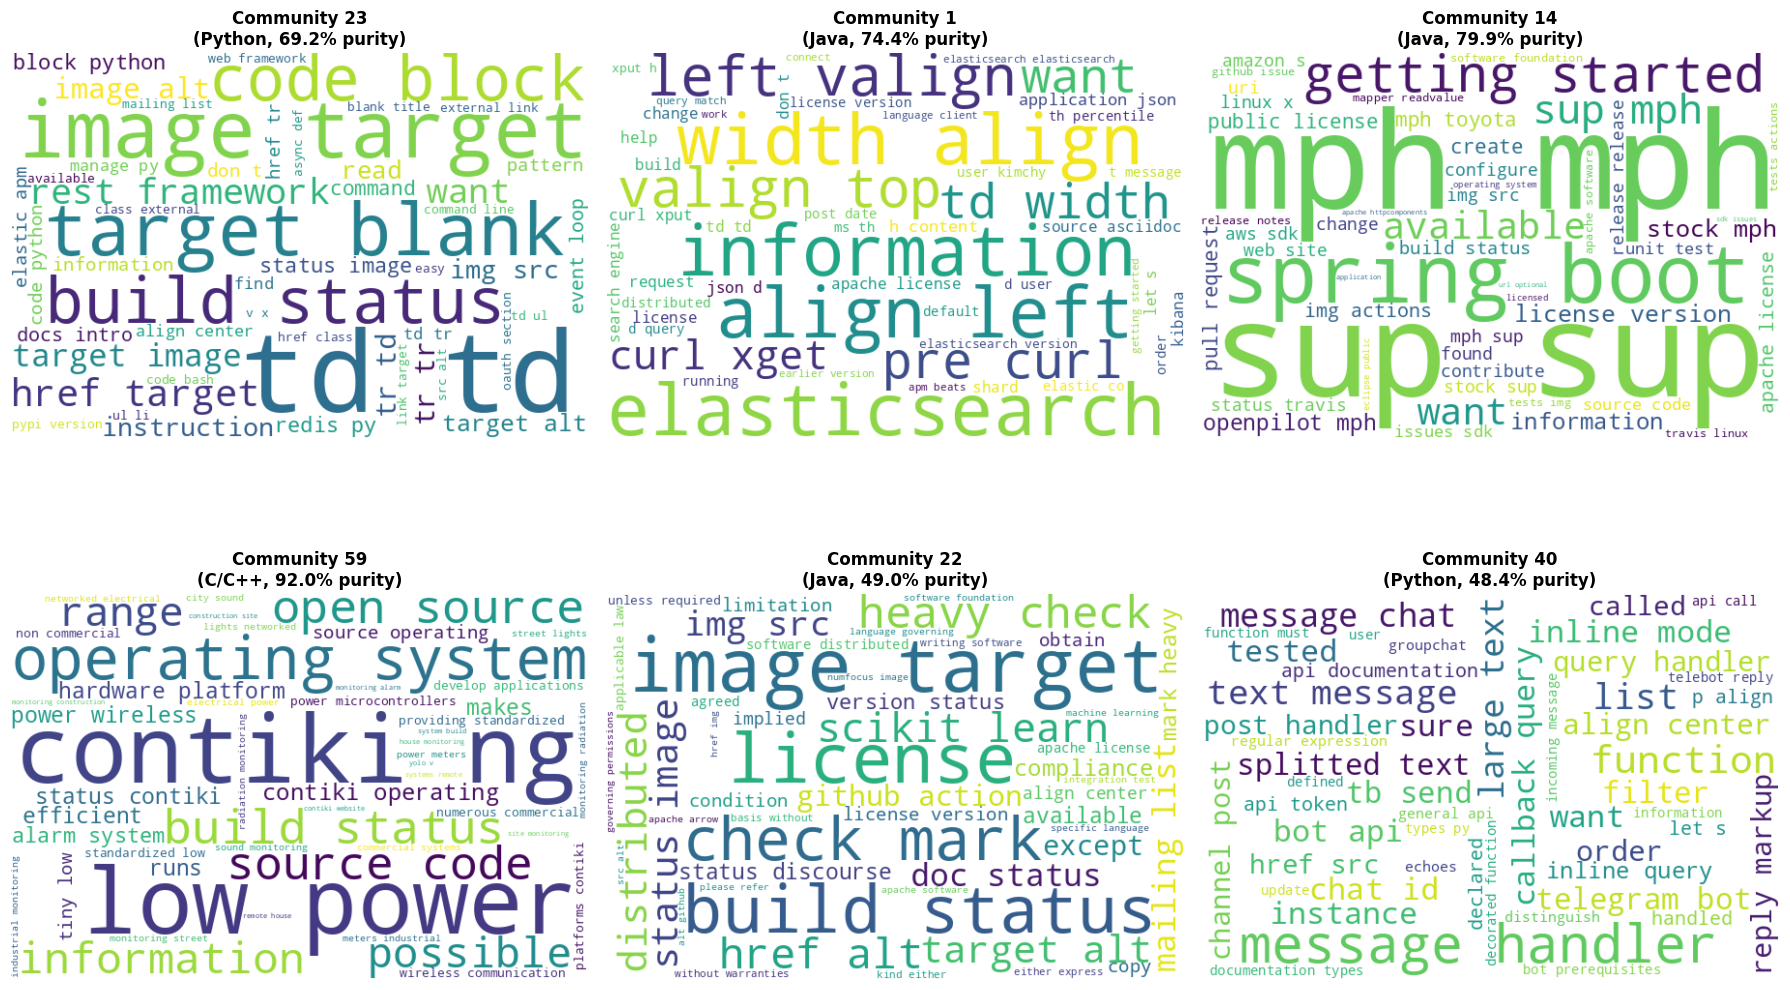

In [24]:
def create_community_wordclouds(community_texts):
    # Custom stopwords
    custom_stopwords = STOPWORDS.copy()
    custom_stopwords.update([
        'use', 'used', 'using', 'run', 'file', 'will', 'one', 'two',
        'project', 'new', 'set', 'may', 'also', 'see', 'get', 'make',
        'example', 'install', 'start', 'first', 'need', 'add', 'name',
        'following', 'via', 'note', 'number', 'type', 'value', 'result',
        'allow', 'include', 'provide', 'contain', 'based', 'support'
    ])

    # Create subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    for idx, (comm_id, text) in enumerate(community_texts.items()):
        # Get dominant language
        if comm_id in comm_langs_normalized:
            langs = comm_langs_normalized[comm_id]
            top_lang = max(langs, key=langs.get)
            purity = (langs[top_lang] / sum(langs.values()) * 100)
        else:
            top_lang = "Unknown"
            purity = 0

        # Create wordcloud
        wordcloud = WordCloud(
            width=600,
            height=400,
            background_color='white',
            max_words=50,
            stopwords=custom_stopwords,
            colormap='viridis'
        ).generate(text)

        # Plot
        axes[idx].imshow(wordcloud, interpolation='bilinear')
        axes[idx].axis('off')
        axes[idx].set_title(f'Community {comm_id}\n({top_lang}, {purity:.1f}% purity)',
                           fontsize=12, fontweight='bold')

    # Hide extra subplot if we have fewer than 6 communities
    if len(community_texts) < 7:
        for idx in range(len(community_texts), 6):
            axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

# Create wordclouds
create_community_wordclouds(community_texts)

# Small World Property
Test the "six degrees of separation" hypothesis by sampling random path lengths in the network.

In [25]:
def shortest_path_between_users(G, source_user, target_user):
    if source_user not in G:
        raise ValueError(f"User '{source_user}' not found in graph")

    if target_user not in G:
        raise ValueError(f"User '{target_user}' not found in graph")

    try:
        path = nx.shortest_path(G, source=source_user, target=target_user)
        return path
    except nx.NetworkXNoPath:
        raise nx.NetworkXNoPath(
            f"No path found from '{source_user}' to '{target_user}'"
        )


shortest_path_between_users(G, 'Pakkutaq', 'torvalds')

['Pakkutaq', 'HLLissau', 'pabigot', 'dwmw2', 'torvalds']

In [26]:

def test_small_world(G, num_samples=10000):
    nodes = list(G.nodes())
    path_lengths = []
    no_path_count = 0

    print(f"Testing {num_samples} random node pairs...\n")

    for i in range(num_samples):
        # Pick two random nodes
        node1, node2 = random.sample(nodes, 2)

        try:
            # Use your existing function
            path = shortest_path_between_users(G, node1, node2)
            path_length = len(path) - 1  # Number of edges
            path_lengths.append(path_length)

            if i < 10:  # Show first 10 examples
                print(f"{i+1}. {node1} → {node2}: {path_length} steps")

        except (nx.NetworkXNoPath, ValueError):
            no_path_count += 1
            if i < 10:
                print(f"{i+1}. {node1} → {node2}: No path (disconnected)")

    # Statistics
    if path_lengths:
        print(f"\n{'='*60}")
        print(f"Results from {len(path_lengths)} connected pairs:")
        print(f"  Average path length: {np.mean(path_lengths):.2f}")
        print(f"  Median path length: {np.median(path_lengths):.1f}")
        print(f"  Min path length: {min(path_lengths)}")
        print(f"  Max path length: {max(path_lengths)}")

    return path_lengths

# Run experiment
path_lengths = test_small_world(G, num_samples=len(G.nodes()))

Testing 47579 random node pairs...

1. RedNax67 → stefanfreitag: 4 steps
2. Vlad-Shcherbina → JoelMarcey: 3 steps
3. sandi-inforit → akhilkumarpilli: 4 steps
4. jspricke → podollb: 4 steps
5. gustaebel → GJL: 4 steps
6. akshay-joshi → vandycknick: 4 steps
7. reynaldo → sahlberg: 3 steps
8. byehack → easyice: 4 steps
9. bodgit → jasonbosco: 2 steps
10. GregMefford → nishanttotla: 2 steps

Results from 47579 connected pairs:
  Average path length: 3.55
  Median path length: 4.0
  Min path length: 1
  Max path length: 8


# Sentiment Analysis
Analyze the sentiment of README texts using VADER sentiment analyzer.

In [27]:
# Ensure the VADER lexicon is available
try:
    sia = SentimentIntensityAnalyzer()
except LookupError:
    nltk.download("vader_lexicon")
    sia = SentimentIntensityAnalyzer()

def compute_sentiment_scores(texts):
    """
    Compute VADER compound sentiment scores for a list of texts.
    Returns a NumPy array of scores in [-1, 1].
    """
    scores = []
    for txt in texts:
        if not txt:
            continue
        txt = txt.strip()
        if not txt:
            continue
        score = sia.polarity_scores(txt)["compound"]
        scores.append(score)
    return np.array(scores, dtype=float)

In [ ]:
# Overall sentiment for all cleaned READMEscleaned_readmes = clean_readmes(readmes)
overall_sentiment = compute_sentiment_scores(cleaned_readmes)

n = len(overall_sentiment)
print(f"Overall README sentiment (n = {n})")

if n > 0:
    mean_val = overall_sentiment.mean()
    median_val = np.median(overall_sentiment)
    min_val = overall_sentiment.min()
    max_val = overall_sentiment.max()

    # Simple polarity buckets
    pos = (overall_sentiment > 0.05).sum()
    neg = (overall_sentiment < -0.05).sum()
    neu = n - pos - neg

    print(f"  mean       : {mean_val:.3f}")
    print(f"  median     : {median_val:.3f}")
    print(f"  min / max  : {min_val:.3f} / {max_val:.3f}")
    print(f"  positive   : {pos} ({pos / n * 100:.1f}%)")
    print(f"  neutral    : {neu} ({neu / n * 100:.1f}%)")
    print(f"  negative   : {neg} ({neg / n * 100:.1f}%)")
else:
    print("  No non-empty README texts to analyse.")


# Sentiment per community (top K structural communities)

def compute_community_sentiment(partition, repo_data, sizes, top_k=5):
    """
    For the top_k structural communities (by size), compute sentiment statistics
    over the READMEs belonging to users in each community.
    """
    results = {}

    for rank, (comm_id, size) in enumerate(sizes[:top_k], 1):
        # Get raw READMEs for this community (from existing helper)
        readmes = get_community_readmes(comm_id, partition, repo_data)

        # Clean them with your existing cleaner, then compute sentiment
        cleaned = [clean_readme_text(t) for t in readmes if t]
        scores = compute_sentiment_scores(cleaned)

        if len(scores) == 0:
            print(f"Community {comm_id}: no README texts")
            continue

        stats = {
            "rank": rank,
            "nodes": size,
            "n_readmes": len(scores),
            "mean": float(scores.mean()),
            "median": float(np.median(scores)),
            "min": float(scores.min()),
            "max": float(scores.max()),
            "pos_frac": float((scores > 0.05).sum() / len(scores)),
            "neg_frac": float((scores < -0.05).sum() / len(scores)),
        }
        results[comm_id] = stats

    return results


community_sentiment = compute_community_sentiment(
    partition,
    repo_data,
    sizes,
    top_k=5
)

print("\nCommunity sentiment summary (top structural communities):")
for comm_id, stats in community_sentiment.items():
    print(
        f"Community {comm_id} "
        f"(rank {stats['rank']}, {stats['nodes']} nodes, {stats['n_readmes']} READMEs)\n"
        f"  mean={stats['mean']:.3f}, median={stats['median']:.3f}, "
        f"min={stats['min']:.3f}, max={stats['max']:.3f}\n"
        f"  positive fraction={stats['pos_frac']:.2f}, "
        f"negative fraction={stats['neg_frac']:.2f}\n"
    )


Overall README sentiment (n = 3533)
  mean       : 0.479
  median     : 0.660
  min / max  : -0.999 / 1.000
  positive   : 2464 (69.7%)
  neutral    : 688 (19.5%)
  negative   : 381 (10.8%)

Community sentiment summary (top structural communities):
Community 23 (rank 1, 2630 nodes, 4105 READMEs)
  mean=0.731, median=0.951, min=-0.995, max=1.000
  positive fraction=0.90, negative fraction=0.08

Community 1 (rank 2, 2486 nodes, 19793 READMEs)
  mean=0.684, median=0.941, min=-0.997, max=1.000
  positive fraction=0.82, negative fraction=0.15

Community 14 (rank 3, 1900 nodes, 2789 READMEs)
  mean=0.724, median=0.937, min=-0.940, max=1.000
  positive fraction=0.88, negative fraction=0.07

Community 59 (rank 4, 1727 nodes, 10741 READMEs)
  mean=0.141, median=0.202, min=-0.999, max=1.000
  positive fraction=0.51, negative fraction=0.44

Community 22 (rank 5, 1674 nodes, 2508 READMEs)
  mean=0.701, median=0.912, min=-0.999, max=1.000
  positive fraction=0.90, negative fraction=0.06

